# Advanced DL and RL: Домашнее задание 1
Студент: Клюенков Владимир

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
        
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
* hit  — взять ещё одну карту;
* stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [73]:
import gym
env = gym.make('Blackjack-v0', natural=True)
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [67]:
%%time
num_episodes = 1000000
average_reward = 0

def simplest_policy(state):
    if state[0] >= 19: 
        return 0
    else:
        return 1
    
    
for i in range(num_episodes):
    state = env.reset()
    is_done = False
    while not is_done:
        action = simplest_policy(state)
        state, reward, is_done, _ = env.step(action)
    average_reward += (reward - average_reward) / (i + 1)
    
print(f"Выигрыш от наивной стратегии: {average_reward}")

Выигрыш от наивной стратегии: -0.18129199999999868
CPU times: user 54.4 s, sys: 26.6 ms, total: 54.5 s
Wall time: 54.6 s


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

####  Q-обучение

In [75]:
class Qlearning:
    def __init__(self, alpha=0.00001, gamma=1, eps=0.1):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        env == 'Blackjack-v0'
        self.env = gym.make('Blackjack-v0', natural=True)
        self.na = self.env.action_space.n
        self.action_space = list(range(self.na))
    
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()
        done = False
        steps = []
        while not done:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, done, _ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for n in range(num_episodes):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        average_reward = 0
        for i in range(num_episodes):
            state = self.env.reset()
            is_done = False
            while not is_done:
                action = self.get_next_action(state)
                state, reward, is_done, _ = self.env.step(action)
            average_reward += (reward - average_reward) / (i + 1)
        #print(f"Средний выигрыш после {num_episodes} эпизодов Q-learning: {average_reward}")
        return average_reward

In [63]:
%%time
QL = Qlearning()
QL.train(num_episodes=100000)
average_reward, rewards = QL.inference(num_episodes=100000)

Средний выигрыш после 100000 эпизодов Q-learning: -0.053804999999999825
CPU times: user 13.2 s, sys: 120 ms, total: 13.3 s
Wall time: 13.2 s


#### Monte Carlo control

In [125]:
from collections import defaultdict
import random
def get_epsilon(N_state_count, N_zero=100):
    return N_zero / (N_zero + N_state_count)

def get_action(Q, state, state_count, action_size):
    random_action = random.randint(0, action_size - 1)
    best_action = np.argmax(Q[state])
    epsilon = get_epsilon(state_count)
    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def MC_inference(Q, num_episodes=100000):
    average_reward = 0
    for i in range(num_episodes):
        state = env.reset()
        is_done = False
        while not is_done:
            action = np.argmax(Q[state])
            state, reward, is_done, _ = env.step(action)
        average_reward += (reward - average_reward) / (i + 1)
    #print(f"Средний выигрыш после {num_episodes} эпизодов Monte Carlo control: {average_reward}")
    return average_reward


def evaluate_policy(Q, episodes=10000):
    wins = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _ = env.step(action=action)
        if reward > 0:
            wins += 1
    return wins / episodes

def monte_carlo(gamma=1., episodes=5000, evaluate=False):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)
    
    evaluations = []
    for i in range(episodes):
        if evaluate and i % 1000 == 0:
            evaluations.append(evaluate_policy(Q))
        episode = []
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1
            action = get_action(Q, state, state_count[state], env.action_space.n)
            new_state, reward, done, _ = env.step(action=action)
            episode.append((state, action, reward))
            state = new_state
        G = 0
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count
    return Q, evaluations

In [123]:
Q_mc, evaluations = monte_carlo(episodes=100000)
MC_inference(Q_mc, num_episodes=100000)

Средний выигрыш после 100000 эпизодов Monte Carlo control: -0.040160000000000605


-0.040160000000000605

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Попробуем подобрать оптимальные параметры при помощи grid search.

#### Grid search q-learning and plot

In [80]:
%%time
best_sum_of_rewards = -0.18 # need better that dummy strategy
best_alpha = 0
best_eps = 0
for alpha in tqdm(np.linspace(0.0001, 0.01, 15)):
    for eps in np.linspace(0.05, 0.5, 15):
        QL = Qlearning(alpha=alpha, eps=eps)
        QL.train(10000)
        sum_of_rewards = QL.inference()
        if sum_of_rewards > best_sum_of_rewards:
            best_sum_of_rewards = sum_of_rewards
            best_alpha = alpha
            best_eps = eps

print(f"Лучший выигрыш: {best_sum_of_rewards}, alpha: {best_alpha}, eps: {best_eps}")


100%|██████████| 15/15 [31:29<00:00, 125.94s/it]

Лучший выигрыш: -0.042539999999999634, alpha: 0.0001, eps: 0.4035714285714286
CPU times: user 31min 20s, sys: 14.3 s, total: 31min 34s
Wall time: 31min 29s


In [97]:
%%time

QL = Qlearning(alpha=0.0001, eps=0.40357)
sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    QL.train(1000)
    sum_of_rewards = QL.inference()
    sums_of_rewards.append(sum_of_rewards)


100%|██████████| 100/100 [15:31<00:00,  9.31s/it]

CPU times: user 15min 19s, sys: 6.68 s, total: 15min 26s
Wall time: 15min 36s


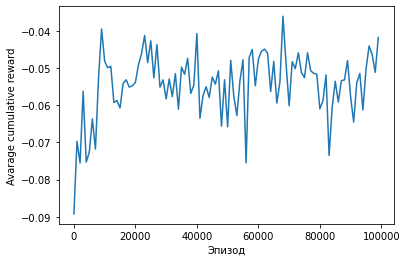

In [99]:
plt.plot(range(0,100000,1000), sums_of_rewards)
plt.xlabel('Эпизод')
plt.ylabel('Avarage cumulative reward')
plt.show()

#### Grid search Monte Carlo control and plot

In [126]:
%%time
best_sum_of_rewards = -0.18 # need better that dummy strategy
best_gamma = 0

for gamma in tqdm(np.linspace(0., 1, 100)):
    Q_mc, evaluations = monte_carlo(gamma=1., episodes=5000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    if sum_of_rewards > best_sum_of_rewards:
        best_sum_of_rewards = sum_of_rewards
        best_gamma = gamma

print(f"Лучший выигрыш: {best_sum_of_rewards}, best_gamma: {best_gamma}")



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:06<11:30,  6.97s/it]

  2%|▏         | 2/100 [00:14<11:35,  7.10s/it]

  3%|▎         | 3/100 [00:21<11:21,  7.02s/it]

  4%|▍         | 4/100 [00:28<11:21,  7.10s/it]

  5%|▌         | 5/100 [00:36<11:51,  7.49s/it]

  6%|▌         | 6/100 [00:45<12:17,  7.84s/it]

  7%|▋         | 7/100 [00:54<12:41,  8.19s/it]

  8%|▊         | 8/100 [01:03<12:58,  8.46s/it]

  9%|▉         | 9/100 [01:12<13:07,  8.66s/it]

 10%|█         | 10/100 [01:21<13:12,  8.81s/it]

 11%|█         | 11/100 [01:30<13:10,  8.89s/it]

 12%|█▏        | 12/100 [01:39<12:49,  8.74s/it]

 13%|█▎        | 13/100 [01:47<12:16,  8.46s/it]

 14%|█▍        | 14/100 [01:55<11:53,  8.30s/it]

 15%|█▌        | 15/100 [02:03<11:35,  8.18s/it]

 16%|█▌        | 16/100 [02:11<11:41,  8.35s/it]

 17%|█▋        | 17/100 [02:19<11:26,  8.27s/it]

 18%|█▊        | 18/100 [02:27<11:05,  8.12s/it]

 19%|█▉        | 19/100 [02:35<10:54,  8.08s/it]

 20%|██        |

Лучший выигрыш: -0.07829500000000111, best_gamma: 0.6060606060606061
CPU times: user 12min 48s, sys: 6.53 s, total: 12min 55s
Wall time: 1h 28min 1s


In [ ]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(50)):
    Q_mc, evaluations = monte_carlo(gamma=1, episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)




  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:05<04:49,  5.90s/it]


  4%|▍         | 2/50 [00:13<05:00,  6.26s/it]


  6%|▌         | 3/50 [00:20<05:10,  6.61s/it]


  8%|▊         | 4/50 [00:27<05:05,  6.65s/it]


 10%|█         | 5/50 [00:34<05:12,  6.95s/it]


 12%|█▏        | 6/50 [00:43<05:27,  7.45s/it]

Text(0, 0.5, 'win rate')

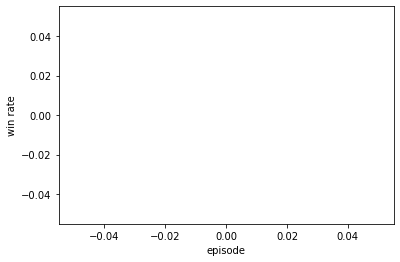

In [131]:
plt.plot([i * 1000 for i in range(len(evaluations))], evaluations)
plt.xlabel('episode')
plt.ylabel('win rate')

In [ ]:
%%time

sums_of_rewards = []
best_sum_of_rewards = [QL.inference()]
for i in tqdm(range(100)):
    Q_mc, evaluations = monte_carlo(gamma=1., episodes=i*1000, evaluate=False)
    sum_of_rewards = MC_inference(Q_mc, num_episodes=100000)
    sums_of_rewards.append(sum_of_rewards)

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:


* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.



6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде.

Реализуем систему подсчёта карт «Половинки».

### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.